In [26]:
import matplotlib.pyplot as plt
import numpy as np
import nidaqmx as dx
from scipy.signal import sawtooth, square
from scipy.fft import rfft, rfftfreq, irfft
from time import sleep
import sounddevice as sd
from scipy.io.wavfile import write
import os
import time

class MyDAQ:
    def __init__(self):
        self.__samplerate = None
        self.__name = None

    @property
    def samplerate(self) -> int:
        return self.__samplerate

    @samplerate.setter
    def samplerate(self, newSamplerate: int) -> None:
        assert isinstance(newSamplerate, int), "Samplerate should be an integer."
        assert newSamplerate > 0, "Samplerate should be positive."
        self.__samplerate = newSamplerate

    @property
    def name(self) -> str:
        return self.__name

    @name.setter
    def name(self, newName: str) -> None:
        assert isinstance(newName, str), "Name should be a string."
        self.__name = newName

    def _addOutputChannels(self, task: dx.task.Task, channels: str | list[str]) -> None:
        """
        Add output channels to the DAQ
        """
        assert not (self.name is None), "Name should be set first."

        # Make sure channels can be iterated over
        if isinstance(channels, str):
            channels = [channels]

        # Iterate over all channels and add to task
        for channel in channels:
            if self.name in channel:
                task.ao_channels.add_ao_voltage_chan(channel)
            else:
                task.ao_channels.add_ao_voltage_chan(f"{self.name}/{channel}")

    def _addInputChannels(self, task: dx.task.Task, channels: str | list[str]) -> None:
        """
        Add input channels to the DAQ
        """
        assert not (self.name is None), "Name should be set first."

        # Make sure channels can be iterated over
        if isinstance(channels, str):
            channels = [channels]

        # Iterate over all channels and add to task
        for channel in channels:
            if self.name in channel:
                task.ai_channels.add_ai_voltage_chan(channel)
            else:
                task.ai_channels.add_ai_voltage_chan(f"{self.name}/{channel}")

    def _configureChannelTimings(self, task: dx.task.Task, samples: int) -> None:
        """
        Set the correct timings for task based on number of samples
        """
        assert not (self.samplerate is None), "Samplerate should be set first."

        task.timing.cfg_samp_clk_timing(
            self.samplerate,
            sample_mode=dx.constants.AcquisitionType.FINITE,
            samps_per_chan=samples,
        )

    @staticmethod
    def convertDurationToSamples(samplerate: int, duration: float) -> int:
        samples = duration * samplerate

        # Round down to nearest integer
        return int(samples)

    @staticmethod
    def convertSamplesToDuration(samplerate: int, samples: int) -> float:
        duration = samples / samplerate

        return duration

    def read(self, duration: float, *channels: str, timeout: float = 300) -> np.ndarray:
        """
        Read from user-specified channels for `duration` seconds
        """

        # Convert duration to samples
        samples = MyDAQ.convertDurationToSamples(self.samplerate, duration)

        # Create read task
        with dx.Task("readOnly") as readTask:
            self._addInputChannels(readTask, channels)
            self._configureChannelTimings(readTask, samples)

            # Now read in data. Use WAIT_INFINITELY to assure ample reading time
            data = readTask.read(number_of_samples_per_channel=samples, timeout=timeout)

        return np.asarray(data)

    def write(self, voltages: np.ndarray, *channels: str) -> None:
        """
        Write `voltages` to user-specified channels.
        """
        samples = max(voltages.shape)

        # Create write task
        with dx.Task("writeOnly") as writeTask:
            self._addOutputChannels(writeTask, channels)
            self._configureChannelTimings(writeTask, samples)

            # Now write the data
            writeTask.write(voltages, auto_start=True)

            # Wait for writing to finish
            sleep(samples / self.samplerate + 1 / 1000)
            writeTask.stop()

    def readwrite(
        self,
        voltages: np.ndarray,
        readChannels: str | list[str],
        writeChannels: str | list[str],
        timeout: float = 300,
    ) -> np.ndarray:
        samples = max(voltages.shape)

        with dx.Task("read") as readTask, dx.Task("write") as writeTask:
            self._addOutputChannels(writeTask, writeChannels)
            self._addInputChannels(readTask, readChannels)

            self._configureChannelTimings(writeTask, samples)
            self._configureChannelTimings(readTask, samples)

            # Start writing. Since reading is a blocking function, there
            # is no need to sleep and wait for writing to finish.
            writeTask.write(voltages)

            writeTask.start()
            data = readTask.read(number_of_samples_per_channel=samples, timeout=timeout)

            return np.asarray(data)

    @staticmethod
    def generateWaveform(
        function,
        samplerate: int,
        frequency: float,
        amplitude: float = 1,
        phase: float = 0,
        duration: float = 1,
        phaseInDegrees: bool = True,
    ) -> np.ndarray:
        """
        Geneate a waveform from the 4 basic wave parameters

        Parameters
        ----------
        function : str or callable
            Type of waveform. The parameters `amplitude`, `frequency` and `phase`
            are passed to the callable.
        samplerate: int
            Samplerate with which to sample waveform.
        frequency : int or float
            Frequency of the waveform.
        amplitude : int or float, optional
            Amplitude of the waveform in volts. The default is 1.
        phase : int or float, optional
            Phase of the waveform in degrees. The default is 0.
        duration : int or float, optional
            Duration of the waveform in seconds. The default is 1.
        phaseInDegrees: bool, optional
            Whether phase is given in degrees. The default is True

        Returns
        -------
        timeArray : ndarray
            ndarray containing the discrete times at which the waveform is evaluated.
        wave : ndarray
            ndarray of the evaluated waveform.

        """
        timeArray = MyDAQ.getTimeArray(duration, samplerate)
        if phaseInDegrees:
            phase = np.deg2rad(phase)

        if not callable(function):
            function = MyDAQ.findFunction(function)

        wave = function(timeArray, amplitude, frequency, phase)

        return timeArray, wave

    @staticmethod
    def findFunction(function: str):
        match function:
            case "sine":
                return lambda x, A, f, p: A * np.sin(2 * np.pi * f * x + p)
            case "square":
                return lambda x, A, f, p: A * square(2 * np.pi * f * x + p)
            case "sawtooth":
                return lambda x, A, f, p: A * sawtooth(2 * np.pi * f * x + p)
            case "isawtooth":
                return lambda x, A, f, p: A * sawtooth(2 * np.pi * f * x + p, width=0)
            case "triangle":
                return lambda x, A, f, p: A * sawtooth(2 * np.pi * f * x + p, width=0.5)
            case _:
                raise ValueError(f"{function} is not a recognized wavefront form")

    @staticmethod
    def getTimeArray(duration: float, samplerate: int) -> np.ndarray:
        steps = MyDAQ.convertDurationToSamples(samplerate, duration)
        return np.linspace(1 / samplerate, duration, steps)


    @staticmethod
    def performRFFT(data: np.ndarray, samplerate : int, norm='forward'):

        complex_coefficients = rfft(data, norm=norm)
        frequencies = rfftfreq(len(data), 1 / samplerate)
        if norm =='forward':
            complex_coefficients[1:-1] *= 2  # Correct scaling to show accurate 
        
        if norm =='backward':
            pass
        return frequencies, complex_coefficients
    
    @staticmethod
    def performIRFFT(complex_coefficients, norm='forward'):
        complex_coefficients[1:-1] /= 2    
        original_data = irfft(complex_coefficients, norm=norm)    
        return original_data
    

    def __str__(self) -> str:
        """
        Only used for pretty printing of class
        E.g. using `print(MyDAQ)` will neatly print the most important
        properties
        """
        title = f"MyDAQ instance"

        return (
            title
            + f"\n{'=' * len(title)}"
            + f"\nBase name: {self.name}"
            + f"\nSample rate: {self.samplerate}"
        )

    @staticmethod
    def remove_magnitude(complex_coefficients: np.ndarray, threshold=0.1) -> np.ndarray:
        """
        Remove the magnitude information from FFT data while keeping phase intact.
        This sets the magnitude of each frequency component to 1.
        """
        # Get the phase of the complex coefficients
        phase = np.angle(complex_coefficients)

        magnitude = np.abs(complex_coefficients)
        # Recreate the complex coefficients with magnitude 1 but the same phase
        magnitude_removed_coefficients = np.exp(1j * phase) * 0.1*np.max(magnitude) # e^(i*phase)

        return magnitude_removed_coefficients
    
            # Apply the threshold for peak detection
        # normalized_magnitude = np.where(magnitude >= threshold * np.max(magnitude), np.max(magnitude), magnitude)

        # # Recombine the magnitude and phase into a complex array
        # normalized_complex_coefficients = normalized_magnitude * np.exp(1j * phase)

        # return normalized_complex_coefficients
    

    @staticmethod
    def remove_phase(complex_coefficients: np.ndarray) -> np.ndarray:
        """
        Remove phase information from the complex FFT coefficients,
        leaving only the magnitude information.

        Parameters:
        complex_coefficients (np.ndarray): Array of complex FFT coefficients.

        Returns:
        np.ndarray: Modified complex array with only magnitude information.
        """
        # Retain the magnitude and set phase to zero
        magnitude_only = np.abs(complex_coefficients) * np.exp(1j * 0)  # Phase set to 0

        return magnitude_only
    
    
daq = MyDAQ()










De eerste code blok kan je een sinusgolf of whatever soort golf proberen en die FFT'en en IFFT'en


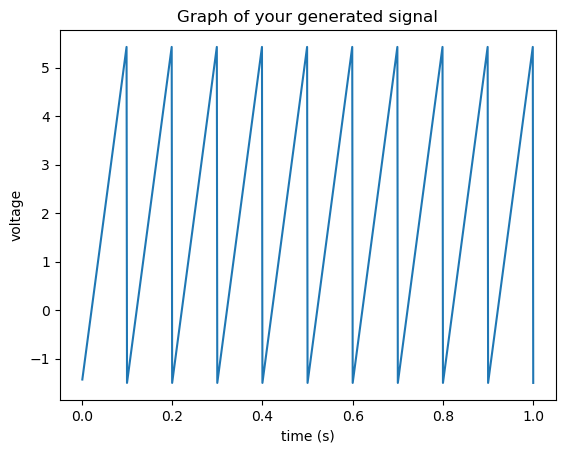

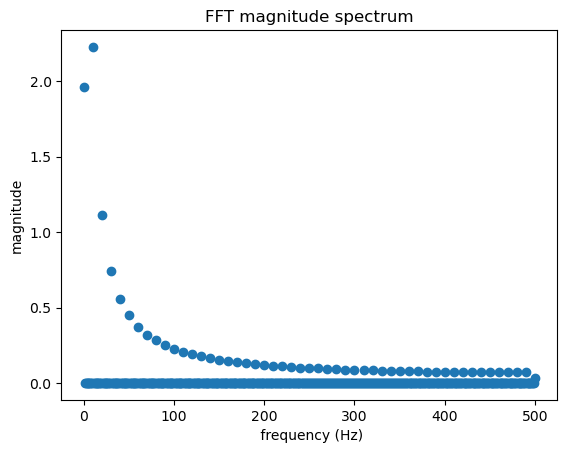

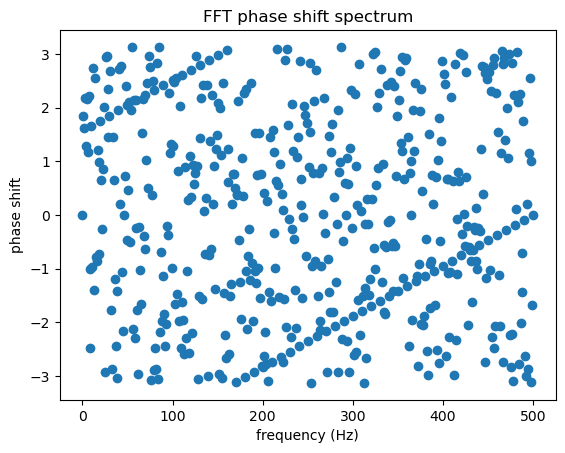

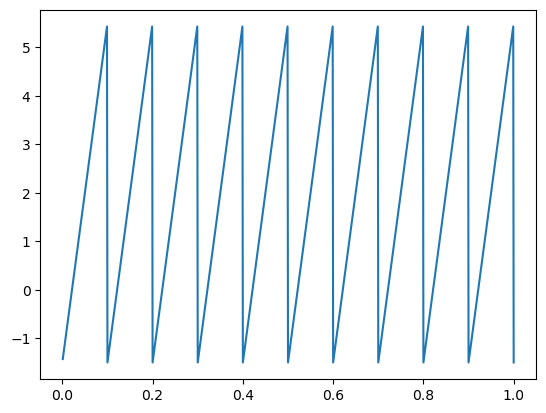

In [30]:
#
# Test case 1 -----------------------------------------------
samplerate = 1000
frequency =  10
duration = 1
x, y= daq.generateWaveform(function='sawtooth', samplerate=samplerate, frequency=frequency, duration=duration, amplitude=3.5, ) 

y= y+2
mask = x < 1.82
# x = x[mask]
# y= y[mask]
plt.plot(x,y)
plt.title('Graph of your generated signal')
plt.xlabel('time (s)')
plt.ylabel('voltage')
plt.show()


norm = 'forward'
frequencies, complex_coefficients = daq.performRFFT(data=y, samplerate=samplerate, norm=norm)
plt.scatter(frequencies, np.abs(complex_coefficients))
plt.title('FFT magnitude spectrum')
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel(' frequency (Hz)')
plt.ylabel('magnitude')
plt.show()

plt.scatter(frequencies, np.angle(complex_coefficients))
plt.title('FFT phase shift spectrum')
plt.xlabel('frequency (Hz)')
plt.ylabel('phase shift')
plt.show()


reconstructed_data = daq.performIRFFT(complex_coefficients)

plt.plot(x, reconstructed_data)
plt.show()

# Test case 1 -----------------------------------------------

In [19]:
# Define the path to the sounds folder
sounds_folder = 'sounds'

# Define the new folder name
# Change this one for a new measurement
new_folder_name = 'ruis'  # Change this to 'guitar' or 'voice' as needed

# Create the full path for the new folder
new_folder_path = os.path.join(sounds_folder, new_folder_name)

# Create the new folder
os.makedirs(new_folder_path, exist_ok=True)  # exist_ok=True prevents an error if the folder already exists

print(f"Folder '{new_folder_name}' created in '{sounds_folder}'")

Folder 'ruis' created in 'sounds'


Met het tweede blok kan je je eigen stem opnemen en opslaan in een bestandje


In [31]:

# Set parameters
duration = 5  # seconds to record
sample_rate = 44100  # CD-quality sample rate
delay = 2  # seconds to wait before recording


# Wait before recording
print(f"Waiting for {delay} seconds...")
time.sleep(delay)

# Record audio from the microphone
print("Recording...")
audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype='float64')
sd.wait()  # Wait for the recording to finish
print("Recording finished!")

# Convert the recorded audio from 2D (channels) to 1D
times = daq.getTimeArray(duration=duration, samplerate=sample_rate)
audio = audio.flatten()
audio_data = np.column_stack((times,audio))

file_name = 'original_data.txt'
file_path_og_data_txt = os.path.join(new_folder_path, file_name)
np.savetxt(file_path_og_data_txt, audio_data, delimiter=',')


file_name = 'original_data.wav'
file_path_og_data_wav = os.path.join(new_folder_path, file_name)
# Normalize audio for .wav file (int16 format)
normalized_audio = np.int16(audio / np.max(np.abs(audio)) * 32767)
write(file_path_og_data_wav, sample_rate, normalized_audio )

Waiting for 2 seconds...


AttributeError: 'numpy.ndarray' object has no attribute 'sleep'

Nu kan je het bestandje gebruiken om verschillende operaties te doen.

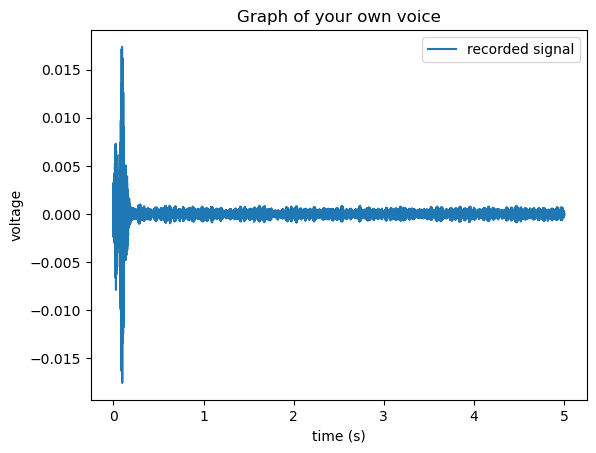

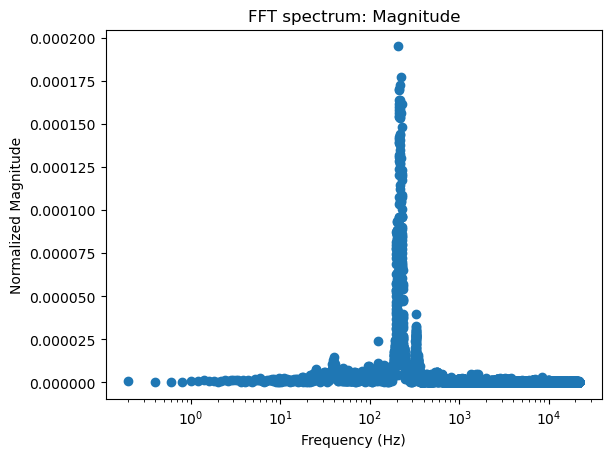

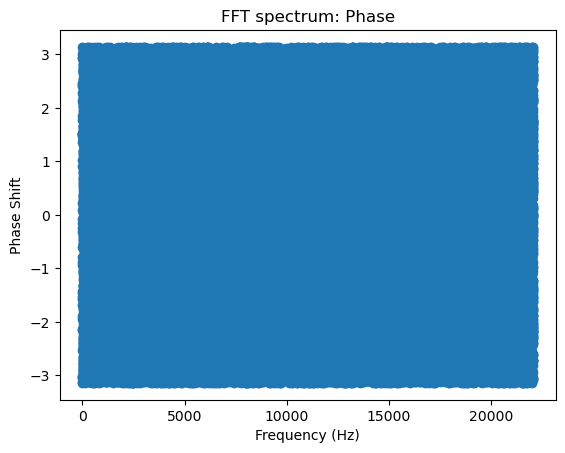

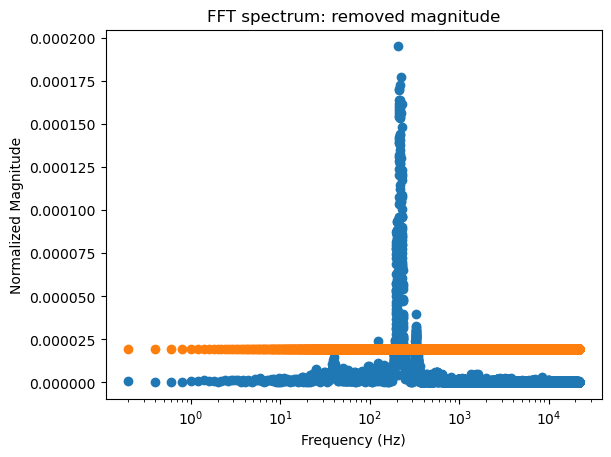

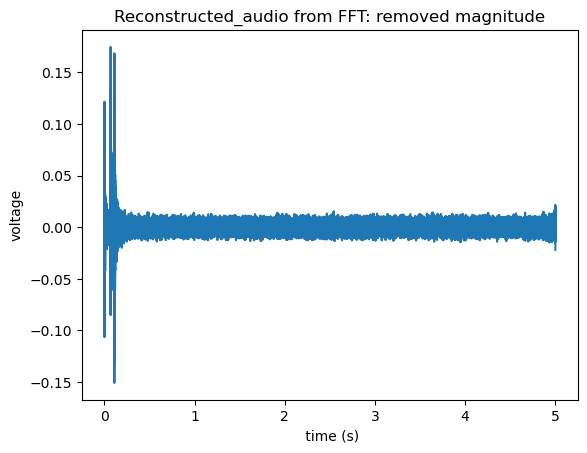

Playing back the recorded audio...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


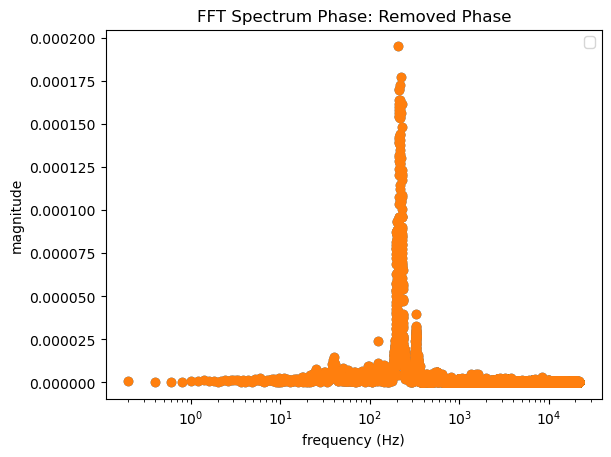

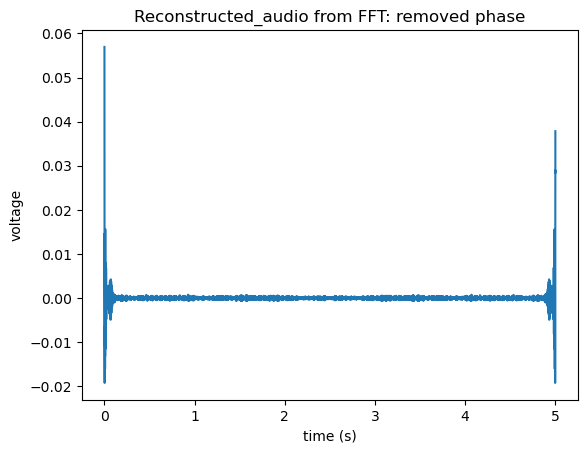

Playing back the recorded audio...


In [21]:

time, audio = np.loadtxt(file_path_og_data_txt, delimiter=',' , unpack=True)

# Plot origina; data -------------------------------------------------------------------------------------------------------------
plt.plot(time, audio, label='recorded signal')
plt.title('Graph of your own voice')
plt.xlabel('time (s)')
plt.ylabel('voltage')
plt.legend()
file_name ='original_data.pdf'
plt.savefig(os.path.join(new_folder_path, file_name))
plt.show()


# Plot FFT magnitudes original data -------------------------------------------------------------------------------------------------------------
frequencies, complex_coefficients = daq.performRFFT(data=audio, samplerate=sample_rate)
plt.scatter(frequencies, np.abs(complex_coefficients))
plt.title('FFT spectrum: Magnitude')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Normalized Magnitude')
plt.xscale('log')
file_name = 'fft_mag.pdf'
plt.savefig(os.path.join(new_folder_path, file_name))
plt.show()

# Plot FFT magnitudes original data -------------------------------------------------------------------------------------------------------------
plt.scatter(frequencies, np.angle(complex_coefficients))
plt.title('FFT spectrum: Phase')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase Shift')
#plt.xscale('log')
file_name= 'fft_phase.pdf'
plt.savefig(os.path.join(new_folder_path, file_name))
plt.show()


# Remove FFT magntiudes and plot -------------------------------------------------------------------------------------------------------------
new_complex_coefficients = daq.remove_magnitude(complex_coefficients)
plt.scatter(frequencies, np.abs(complex_coefficients), label=' original')
plt.scatter(frequencies, np.abs(new_complex_coefficients), label='new')
plt.title('FFT spectrum: removed magnitude')
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Normalized Magnitude')

file_name = 'fft_mag_removed.pdf'
plt.savefig(os.path.join(new_folder_path, file_name))
plt.show()


# Plot reconstructed signal -------------------------------------------------------------------------------------------------------------
reconstructed_audio = daq.performIRFFT(new_complex_coefficients)
plt.plot(time, reconstructed_audio)
plt.title('Reconstructed_audio from FFT: removed magnitude' )
plt.xlabel(' time (s)')
plt.ylabel('voltage')
file_name = 'time_mag_removed.pdf'
plt.savefig(os.path.join(new_folder_path, file_name))
plt.show()

file_name = 'fft_mag_removed.wav'
file_path_fft_mag_removed_wav = os.path.join(new_folder_path, file_name)
# Normalize audio for .wav file (int16 format)
normalized_audio = np.int16(reconstructed_audio  / np.max(np.abs(reconstructed_audio )) * 32767)
write(file_path_fft_mag_removed_wav, sample_rate, normalized_audio )

# Playback the altered audio with normalized magnitudes -----------------------------------------------------------------------------------------------
print("Playing back the recorded audio...")
sd.play(reconstructed_audio, samplerate=sample_rate)
sd.wait()  # Wait until the playback is finished


# Remove Phase info and plot -------------------------------------------------------------------------------------------------------------
new_complex_coefficients = daq.remove_phase(complex_coefficients)
plt.scatter(frequencies, np.abs(complex_coefficients))
plt.scatter(frequencies, np.abs(new_complex_coefficients))
plt.title('FFT Spectrum Phase: Removed Phase')
plt.xscale('log')
plt.xlabel('frequency (Hz)')
plt.ylabel('magnitude')
plt.legend()
file_name ='fft_phase_removed_mag.pdf'
plt.savefig(os.path.join(new_folder_path, file_name))
plt.show()

# Playback the altered audio with removed phase info -----------------------------------------------------------------------------------------------
reconstructed_audio = daq.performIRFFT(new_complex_coefficients)

plt.plot(time, reconstructed_audio)
plt.title('Reconstructed_audio from FFT: removed phase')
plt.xlabel('time (s)')
plt.ylabel('voltage')
plt.show()

file_name = 'fft_phase_removed.wav'
file_path_fft_mag_removed_wav = os.path.join(new_folder_path, file_name)
# Normalize audio for .wav file (int16 format)
normalized_audio = np.int16(reconstructed_audio  / np.max(np.abs(reconstructed_audio )) * 32767)
write(file_path_fft_mag_removed_wav, sample_rate, normalized_audio )

# Playback the altered audio with removed phase info -----------------------------------------------------------------------------------------------
print("Playing back the recorded audio...")
sd.play(reconstructed_audio*10, samplerate=sample_rate)
sd.wait()  # Wait until the playback is finished



Met het derde blok kan je de magnitude informatie verwijderen

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


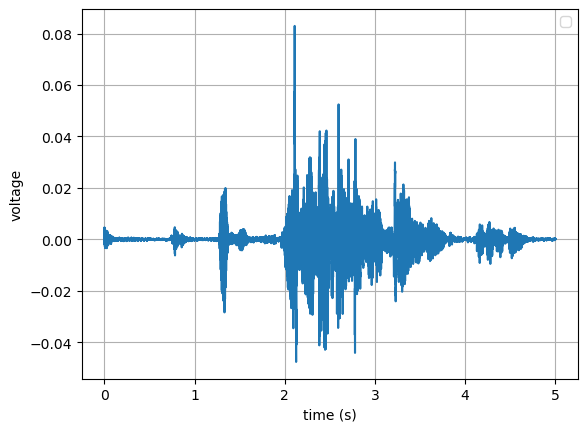

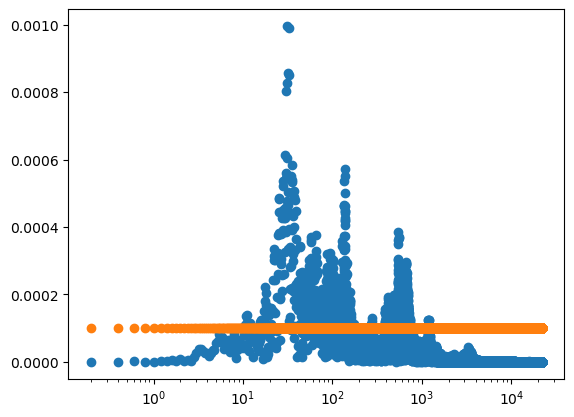

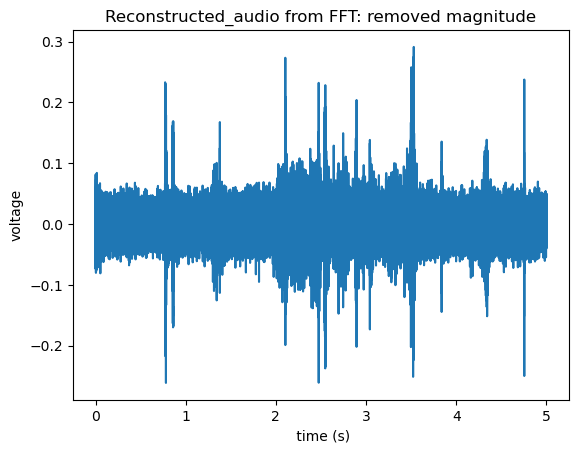

Playing back the recorded audio...


In [16]:
filepath= 'sounds/voice1.txt'

time, audio = np.loadtxt(filepath, delimiter=',' , unpack=True)

plt.plot(time, audio)
plt.xlabel('time (s)')
plt.ylabel('voltage')
plt.grid()
plt.legend()
plt.show()

frequencies, complex_coefficients = daq.performRFFT(data=audio, samplerate=sample_rate)
new_complex_coefficients = daq.remove_magnitude(complex_coefficients)
plt.scatter(frequencies, np.abs(complex_coefficients), label=' original')
plt.scatter(frequencies, np.abs(new_complex_coefficients), label='new')
plt.xscale('log')
plt.show()






reconstructed_audio = daq.performIRFFT(new_complex_coefficients)

plt.plot(time, reconstructed_audio)
plt.title('Reconstructed_audio from FFT: removed magnitude' )
plt.xlabel(' time (s)')
plt.ylabel('voltage')
plt.show()

# Playback the recorded audio
print("Playing back the recorded audio...")
sd.play(reconstructed_audio, samplerate=sample_rate)
sd.wait()  # Wait until the playback is finished
# Test case 3 ----------------------------------------------------------------------------------------

En met het vierde blok kan je de phase  information verwijderen

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


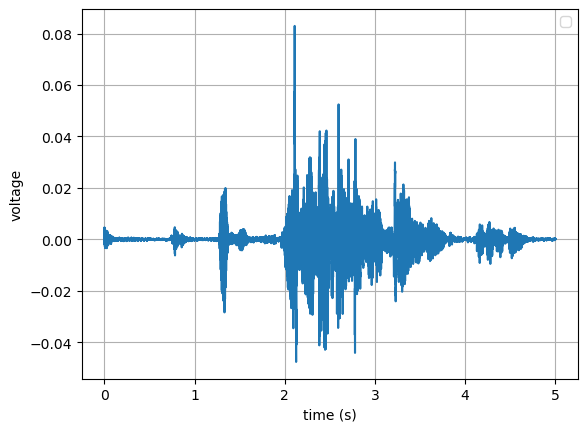

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


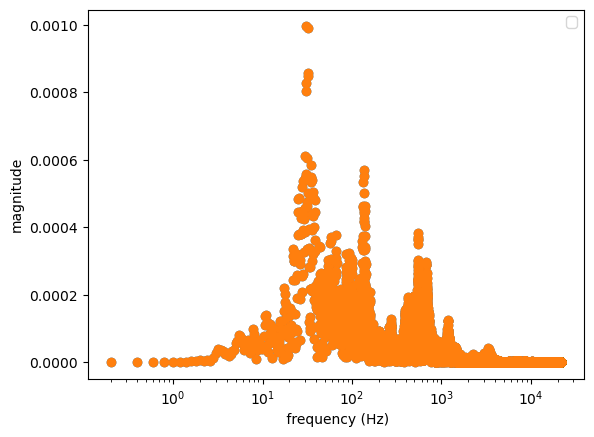

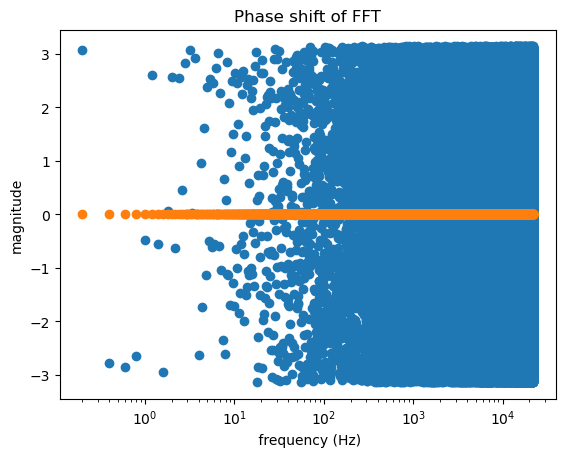

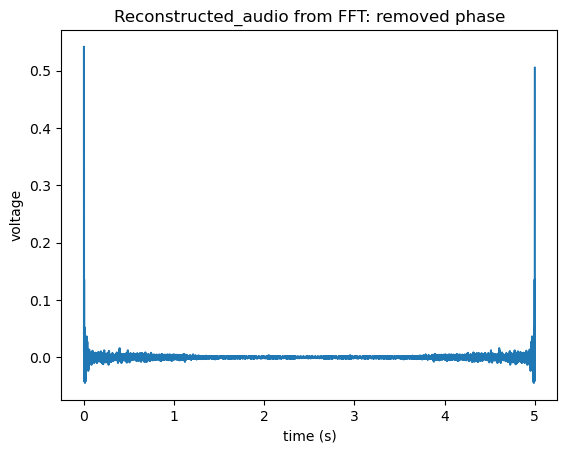

Playing back the recorded audio...


In [17]:
filepath= 'sounds/voice1.txt'

time, audio = np.loadtxt(filepath, delimiter=',' , unpack=True)

plt.plot(time, audio)
plt.xlabel('time (s)')
plt.ylabel('voltage')
plt.grid()
plt.legend()
plt.show()

frequencies, complex_coefficients = daq.performRFFT(data=audio, samplerate=sample_rate)
new_complex_coefficients = daq.remove_phase(complex_coefficients)
plt.scatter(frequencies, np.abs(complex_coefficients))
plt.scatter(frequencies, np.abs(new_complex_coefficients))
plt.xscale('log')
plt.xlabel(' frequency (Hz)')
plt.ylabel('magnitude')
plt.legend()
plt.show()

frequencies, complex_coefficients = daq.performRFFT(data=audio, samplerate=sample_rate)
new_complex_coefficients = daq.remove_phase(complex_coefficients)
plt.scatter(frequencies, np.angle(complex_coefficients))
plt.scatter(frequencies, np.angle(new_complex_coefficients))
plt.title('Phase shift of FFT')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel(' frequency (Hz)')
plt.ylabel('magnitude')
plt.show()



reconstructed_audio = daq.performIRFFT(new_complex_coefficients)

plt.plot(time, reconstructed_audio)
plt.title('Reconstructed_audio from FFT: removed phase')
plt.xlabel('time (s)')
plt.ylabel('voltage')
plt.show()

# Playback the recorded audio
print("Playing back the recorded audio...")
sd.play(reconstructed_audio*10, samplerate=sample_rate)
sd.wait()  # Wait until the playback is finished
# Test case 4 ----------------------------------------------------------------------------------------

In [18]:
# print("Playing back the recorded audio...")
# print("Playing back the recorded audio...")
# sd.play(reconstructed_audio*10, samplerate=sample_rate)
# sd.wait()  # Wait until the playback is finished
# # Test case 4 ----------------------------------------
# sd.play(reconstructed_audio[::-1]*10, samplerate=sample_rate)
# sd.wait()  # Wait until the playback is finished
# # Test case 4 ----------------------------------------